# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)

## >> TO DO (ctrl + f `!!!`)
1) Add link to google slides
2) Background material (section 1)
3) Analyze mesh parameter and interface file (section 3c)
4) Analyze mesher log file (section 3d)
5) Analyze solver log file (section 4)

## Part 1A: Intro to SPECFEM2D

- Day 1A notebook is meant to walk Users through an introduction to `SPECFEM2D`, which includes:
    - navigating a SPECFEM2D working directory
    - generating a 2D mesh with homogeneous halfspace model
    - running forward simulations to generate synthetic seismograms. 
- We will note important files and key steps to take when running SPECFEM. 
- **Objective**: Understanding `SPECFEM2D` to help draw parallels with `SPECFEM3D` and better understand of how software like `SeisFlows` automates SPECFEM
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble*). 
-----------


**Relevant Links:** 
- Day 1 Slides: !!! ADD THIS !!!
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1a_intro_specfem.ipynb)
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_0_container_testing.ipynb
- SPECFEM2D GitHub Repository: https://github.com/geodynamics/specfem2d/tree/devel
- SPECFEM2D Manual: https://specfem2d.readthedocs.io/en/latest/

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


## 1) Background !!! TODO !!!


Potential topics: 
- Seismic waveforms
- Numerical modeling
- Spectral element method
- Meshes

## 2) SPECFEM2D Directory Tour

- In this section we will tour around the SPECFEM2D repository, which is located in `/home/scoped/specfem2d`.  
- **Note** that this directory will not exactly match a directory you clone from GitHub because we have removed a number of large files and directories in order to keep the size of this container reasonable.
- The `devel` branch of all SPECFEM versions contains the most up to date codebase

In [79]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
from seisflows.tools.specfem import Model

%cd /home/scoped/specfem2d

/home/scoped/specfem2d


### a) Binary Executables in *bin/* directory

- In this workshop container, we have already downloaded (git clone), configured (choosing compilers and compiler options) and compiled (make all) SPECFEM2D.  
- The binary executable files are located in the `bin/` directory. 
- Each of these executables performs a different function in the package.

In [2]:
# Let's have a look at the executables
! ls bin

xadj_seismogram		      xconvolve_source_timefunction  xspecfem2D
xcheck_quality_external_mesh  xmeshfem2D		     xsum_kernels
xcombine_sem		      xsmooth_sem


The two most important executables we will be using today are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D`: used to generate our numerical mesh, the skeleton of the domain upon which we run our numerical simulations. 
- `xspecfem2D`: runs the spectral element solver, generating synthetic seismograms for a given source and set of stations.

Some other important executables we will use in Day 2:
- `xsmooth_sem`: smooths volumentric quantities by convolving them with a 2D Gaussian. Users can define the horizontal and vertical half-widths of the Gaussian.
- `xcombine_sem`: combines multiple volumetric quantities, such as summing kernels to form the gradient.

### b) Metadata in *DATA/* directory

- Data that the User will provide to SPECFEM should be stored in the *DATA/* directory. 
- The most important files that we will concern ourselves with are the `Par_file`, `SOURCE` and `STATIONS` files.

    `Par_file`: The parameter file which allows the User to adjust parameters for a given simulation  
    `SOURCE`: Defines source characteristics (e.g., moment tensor, force). **NOTE**: SPECFEM2D and SPECFEM3D have a number of different types of available source files (e.g., SOURCE, FORCESOLUTION, CMTSOLUTION)  
    `STATIONS`: Defines station codes and locations (either Cartesian or geographic). **NOTE**: In SPECFEM2D, station information may also be defined in the `Par_file`

The following commands open these files for the SPECFEM2D example problem

In [4]:
# Look at the DATA/ directory
! ls DATA

Par_file  SOURCE  STATIONS


In [5]:
# Illustrates that the Par_file is an ASCII file with key-value pairs
! head -38 DATA/Par_file

#-----------------------------------------------------------
#
# Simulation input parameters
#
#-----------------------------------------------------------

# title of job
title                           = Test of SPECFEM2D with curved interfaces

# forward or adjoint simulation
# 1 = forward, 2 = adjoint, 3 = both simultaneously
# note: 2 is purposely UNUSED (for compatibility with the numbering of our 3D codes)
SIMULATION_TYPE                 = 1
# 0 = regular wave propagation simulation, 1/2/3 = noise simulation
NOISE_TOMOGRAPHY                = 0
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.

# parameters concerning partitioning
NPROC                           = 4              # number of processes

# time step parameters
# total number of time steps
NSTEP                           = 1600

# duration of a time step (see section "How to choose the time step" of the manual for how to do this)
DT                              = 1.1d-3

#

In [6]:
# The SPECFEM2D SOURCE file defines a 2D seismic source
! cat DATA/SOURCE

## Source 1
source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
xs                              = 2500.          # source location x in meters
zs                              = 2500.          # source location z in meters (zs is ignored if source_surf is set to true, it is replaced with the topography height)
## Source type parameters:
#  1 = elastic force or acoustic pressure
#  2 = moment tensor
# or Initial field type (when initialfield set in Par_file):
# For a plane wave including converted and reflected waves at the free surface:
#  1 = P wave,
#  2 = S wave,
#  3 = Rayleigh wave
# For a plane wave without converted nor reflected waves at the free surface, i.e. with the incident wave only:
#  4 = P wave,
#  5 = S wave
# For initial mode displacement:
#  6 = mode (2,3) of a rectangular membrane
source_type                     = 1
# Source time function:
# In the case of a source located in 

In [7]:
# Sometimes in SPECFEM2D, the Par_file defines station information directly
! head -194 DATA/Par_file | tail -n 16

# first receiver set (repeat these 6 lines and adjust nreceiversets accordingly)
nrec                            = 11             # number of receivers
xdeb                            = 300.           # first receiver x in meters
zdeb                            = 2200.          # first receiver z in meters
xfin                            = 3700.          # last receiver x in meters (ignored if only one receiver)
zfin                            = 2200.          # last receiver z in meters (ignored if only one receiver)
record_at_surface_same_vertical = .true.         # receivers inside the medium or at the surface (z values are ignored if this is set to true, they are replaced with the topography height)

# second receiver set
nrec                            = 11             # number of receivers
xdeb                            = 2500.          # first receiver x in meters
zdeb                            = 2500.          # first receiver z in meters
xfin                            = 250

In [8]:
# However, other examples may define station information using STATIONS files, which is formatted:
# STATION NETWORK X[m] Z[m] burial[m] elevation[m]
! head -5 EXAMPLES/Tape2007/DATA/STATIONS_checker

S000000 AA 2.43610e+05 2.78904e+05 0.0 0.0
S000001 AA 3.38981e+05 1.77849e+05 0.0 0.0
S000002 AA 1.64438e+05 2.94733e+05 0.0 0.0
S000003 AA 9.22250e+04 3.68887e+05 0.0 0.0
S000004 AA 2.90702e+05 2.46865e+05 0.0 0.0


### c) Results stored in *OUTPUT_FILES/* directory

- Any outputs generated by SPECFEM will be stored in the `OUTPUT_FILES/` directory. 
- Outputs include log and error messages, synthetic seismograms, figures, and database files
- Most executables will put their outputs here
- **NOTE:** SPECFEM also maintains a DATABASE directory (typically called `DATABASES_MPI/`) which is used to store large database files containing the entire GLL mesh and model. This directory may be the same as `OUTPUT_FILES/`, or may be it's own separate directory.

In [ ]:
# Currently empty because we have not run any executables
! ls OUTPUT_FILES

## 3) Running the mesher `xmeshfem2D` 

- The first thing we need to do when approaching numerical simulations is to generate our numerical mesh. 
- There are multiple approaches to meshing, such as using external software like Trellis. 
- During this workshop we will use SPECFEM's internal meshing software, known as `Meshfem`.
- We will use two terms to talk about meshing:  
    - *MESH*: a numerical grid which defines coordinate points only (i.e., X and Z in 2D).  
    - *MODEL*: parameter values (e.g., seismic velocity) approximating structure, assigned to locations on the MESH.  

In [ ]:
%cd /home/scoped/specfem2d

### a) Velocity Model Parameters

- In SPECFEM2D, *mesh* and *model* parameters are defined in the `Par_file`.
- There are various parameter options we can use to customize our mesher run.
- The following parameter set allows us to read input values from the `Par_file`  
    `NPROC`: defines the number of processors used to partition the *mesh*  
    `MODEL`: set as 'default' which reads *model* parameters from `Par_file`  

>__NOTE:__ In SPECFEM3D, mesh files are defined separate from the `Par_file` to provide more control over a 3D domain. These files are typically stored in `specfem3d/DATA/meshfem3D_files`.

In [10]:
# Look at the definition of the model in the Par_file
! head -273 DATA/Par_file | tail -n 34

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 4
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs values that are read here are

- In the output above we can see that our `Par_file` defines 4 separate regions, each with varying values for density and velocity.

```bash
REG - RHO   VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0
```
- These regions have **no** sense of space. They only represent material properties.
- These regions will be assigned to parts of the *mesh* in the following section

### b) Meshfem Parameters

- The internal mesher has a set of parameters that allows Users to provide interfaces, geometry, absorbing boundary conditions.
- These parameters allow a User to customize a 2D domain to fit their research problem
- The *mesh* parameters also distribute *model* properties defined above, to specific parts of the mesh


In [11]:
! head -320 DATA/Par_file | tail -n 29

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = ../EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 4000.d0        # abscissa of right side of the model
nx                              = 80             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .false.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions       

In [13]:
# Look at the `interfacesfile` which defines boundary interfaces 
! cat /home/scoped/specfem2d/EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# number of interfaces
 4
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1 (bottom layer)
 20
# layer number 2
 20
# layer number 3 (top layer)
 20


!!! TO DO ANALYZE MESH PARAMETERS AND INTERFACE FILE !!!

### c) Setting Up Meshfem

- We need to set a few `Par_file` parameters to tell SPECFEM to output additional files that will facilitate understanding the outputs of `xmeshfem2D`.
- We will use the `seisflows sempar` commmand to print and edit values from the SPECFEM2D `Par_file`. This is simply a convenience function but can be replaced by bash commands like 'cat' + 'awk', or by opening the `Par_file` with a text editor.


The `sempar` (spectral element method parameter) command syntax is as follows
```python
seisflows sempar -P <Par_file> <key> <value:optional>
```
where <Par_file> is the path the SPECFEM `Par_file`, \<key> represents a parameter in the par file (case-insensitive) and \<value> is an optional parameter to overwrite an existing parameter. 
    

In [15]:
! seisflows sempar -P DATA/Par_file model
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_model binary

MODEL: default
NPROC: 4 -> 4
setup_with_binary_database: 1 -> 1
SAVE_MODEL: binary -> binary


#### Meshfem Parameter Explanations

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (this is the default option)  
`NPROC`: Number of MPI processes to run on. The mesh itself is partitioned into `NPROC` sections, each of which is provided to a separate processor.  
`setup_with_binary_database`: Writes database files in binary format, whereas by default they are not saved  
`SAVE_MODEL`: Write model files in Fortran `binary` format. As opposed to other formats like ASCII

#### Database Files

- Database files are files in which SPECFEM stores its internal representation of mesh and model
- These can take on various formats but in this workshop we store them as Fortran binary files
- SPECFEM3D operates in the same manner, storing mesh and model representations in DATABASE files

### d) Run Meshfem Executable

- This example problem is already set up to run, so we simply execute: `xmeshfem2D` 
- Under the hood, SPECFEM will look for relevant data in the *DATA/* directory
- It then generates our numerical mesh in the *OUTPUT_FILES/* directory. 
- The *model* will not be output until we run the solver (`xspecfem2D`) later in the notebook
- We run the problem with MPI on n=4 processors.
- We also redirect the output to a log file so that we can take a look at different parts of it.

In [16]:
! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

In [17]:
# The log file contains important information on how the mesher ran
! head OUTPUT_FILES/output_meshfem2d.txt


 **********************************************
 *** Specfem 2-D Mesher - MPI version       ***
 **********************************************

 Running Git version of the code corresponding to commit ca31205fdaf69ff41dadcd928502330b40bcbf92
 dating From Date:   Wed Aug 31 14:56:38 2022 -0800

 Reading the parameter file...



In [19]:
# e.g., the mesher has created our STATIONS File
! head -255 OUTPUT_FILES/output_meshfem2d.txt | tail -n 30


 writing the ./DATA/STATIONS file


 There are           22  receivers

 Target positions (x,z) of the           22  receivers

 Receiver            1  =    300.00000000000000        2997.7298908673174     
 Receiver            2  =    640.00000000000000        3008.0430011257899     
 Receiver            3  =    980.00000000000000        3090.8224062492818     
 Receiver            4  =    1320.0000000000000        3283.0303922802987     
 Receiver            5  =    1660.0000000000000        3347.8768862033312     
 Receiver            6  =    2000.0000000000000        3250.0000000000000     
 Receiver            7  =    2340.0000000000000        3197.3138031016656     
 Receiver            8  =    2680.0000000000000        3150.9619872716830     
 Receiver            9  =    3020.0000000000000        3086.5939051292362     
 Receiver           10  =    3360.0000000000000        3042.8523748190692     
 Receiver           11  =    3700.0000000000000        3020.6886767662263     
 R

In [20]:
# The STATIONS file matches what the log file tells us 
! cat DATA/STATIONS

S0001    AA          300.0000000         2997.7298909       0.0         0.0
S0002    AA          640.0000000         3008.0430011       0.0         0.0
S0003    AA          980.0000000         3090.8224062       0.0         0.0
S0004    AA         1320.0000000         3283.0303923       0.0         0.0
S0005    AA         1660.0000000         3347.8768862       0.0         0.0
S0006    AA         2000.0000000         3250.0000000       0.0         0.0
S0007    AA         2340.0000000         3197.3138031       0.0         0.0
S0008    AA         2680.0000000         3150.9619873       0.0         0.0
S0009    AA         3020.0000000         3086.5939051       0.0         0.0
S0010    AA         3360.0000000         3042.8523748       0.0         0.0
S0011    AA         3700.0000000         3020.6886768       0.0         0.0
S0012    AA         2500.0000000         2500.0000000       0.0         0.0
S0013    AA         2500.0000000         2250.0000000       0.0         0.0
S0014    AA 

!!! TODO Look at other parts of the output log file here !!!!

In [23]:
# Database files are stored in the OUTPUT_FILES/ directory as FORTRAN binary (.bin) files
# The Database stores the internal definition of the numerical mesh
! ls OUTPUT_FILES/Database*.bin

OUTPUT_FILES/Database00000.bin	OUTPUT_FILES/Database00002.bin
OUTPUT_FILES/Database00001.bin	OUTPUT_FILES/Database00003.bin


## 4) Running the solver `xspecfem2D`

- The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a forward simulation 
- `xspecfem2D` uses the provided `SOURCE` and `STATIONS` files. 
- We will view some of the parameters to look at how the output synthetic seismograms are generated

In [46]:
%cd /home/scoped/specfem2d

/home/scoped/specfem2d


In [24]:
# Look at the Solver-specific parameters
! head -168 DATA/Par_file | tail -n 32

#-----------------------------------------------------------
#
# Receivers
#
#-----------------------------------------------------------

# receiver set parameters for recording stations (i.e. recording points)
# seismotype : record 1=displ 2=veloc 3=accel 4=pressure 5=curl of displ 6=the fluid potential
seismotype                      = 1              # several values can be chosen. For example : 1,2,4

# interval in time steps for writing of seismograms
# every how many time steps we save the seismograms
# (costly, do not use a very small value; if you use a very large value that is larger than the total number
#  of time steps of the run, the seismograms will automatically be saved once at the end of the run anyway)
NTSTEP_BETWEEN_OUTPUT_SEISMOS   = 10000

# set to n to reduce the sampling rate of output seismograms by a factor of n
# defaults to 1, which means no down-sampling
NTSTEP_BETWEEN_OUTPUT_SAMPLE    = 1

# so far, this option can only be used if all the receivers are in a

### Important Solver Parameters

`seismotype`: Sets the units of the output seismograms. This example outputs in units of 'displacement'  
`USER_T0`: Defines when the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source, and is useful e.g., in cases where you have very short source-receiver distances  
`save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files.

In [25]:
# Run the solver on 4 cores
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

In [26]:
# Again, the log file contains important information on the process
! head OUTPUT_FILES/output_solver.txt


 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************

 Running Git version of the code corresponding to commit ca31205fdaf69ff41dadcd928502330b40bcbf92
 dating From Date:   Wed Aug 31 14:56:38 2022 -0800

 There are            4  MPI processes
 Processes are numbered from 0 to            3


In [31]:
# Mesh and Model parameters are assigned here
! head -280 OUTPUT_FILES/output_solver.txt | tail -n 16

 Mesh dimensions:
   Xmin,Xmax of the whole mesh =    0.0000000000000000        4000.0000000000005     
   Zmin,Zmax of the whole mesh =    0.0000000000000000        3355.8363405549972     

 Material properties:
   MODEL                 : default
   nspec                 :         4800
   assign external model :  F

   setting up material arrays
   all material arrays done

 Domains:
   total number of acoustic elements        =         1380
   total number of elastic elements         =         3420
   total number of poroelastic elements     =            0


In [42]:
# During the simulation, the log file updates the User on progress
! head -1023 OUTPUT_FILES/output_solver.txt | tail -n 33


 ******************************************************************
Time step number     500   t =    0.5489 s out of    1600
 ******************************************************************
 We have done    31.2070045     % of the total
 Max norm of vector field in solid (elastic) =    9.34773833E-02
 Max absolute value of scalar field in fluid (acoustic) =    5218.36914    
 Elapsed time in seconds =    1.2469999790191650     
 Elapsed time in hh:mm:ss =      0 h 00 m 01 s
 Mean elapsed time per time step in seconds =    2.4939999580383299E-003
 Time steps remaining =         1100
 Estimated remaining time in seconds =    2.7433999538421627     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 02 s
 Estimated total run time in seconds =    3.9903999328613278     
 Estimated total run time in hh:mm:ss =      0 h 00 m 03 s
 The run will finish approximately on: Fri Sep 16, 2022 23:34


 Writing PostScript vector plot for time step          500
 drawing displacement vector as s

In [38]:
# The solver writes out model files at the end of the simulation
! head -1400 OUTPUT_FILES/output_solver.txt | tail -n 23


 Total duration of the time loop in seconds =    9.51344299      s
 Total number of time steps =         1600
 Average duration of a time step of the time loop =    5.94590185E-03  s
 Total number of spectral elements in the mesh =         1558
     of which         1435  are regular elements
     and          123  are PML elements.
 Average duration of the calculation per spectral element =    3.81636846E-06  s


 Total duration of the timeloop in seconds, measured using 
 date and time of the system :    9.90999985      s

 Saving model files to directory: ./DATA/
   SAVE_MODEL type: binary

   written to file(s): ./DATA/proc000000_rho.bin
   written to file(s): ./DATA/proc000000_vp.bin
   written to file(s): ./DATA/proc000000_vs.bin
   written to file(s): ./DATA/proc000000_x.bin
   written to file(s): ./DATA/proc000000_z.bin
   written to file(s): ./DATA/proc000000_jacobian.bin



!!! TODO Go through more of the solver log here !!!

## 5) Understanding SPECFEM2D Output Files

- `xspecfem2D` has created a plethora of results
- We will have a look one by one to see what each of these files are, and how they can help us understand our simulation.

### a) Velocity Model

- `xspecfem2D` outputs the velocity model into the *DATA/* directory. 
- We can use some utility functions written into `SeisFlows` to plot this model to help us visualize our domain.
- SPECFEM3D outputs velocity model files in `LOCAL_PATH` which is commonly `OUTPUT_FILES/DATABASES_MPI`
- We'll use Python to visualize results from our simulation

In [47]:
%cd /home/scoped/specfem2d

/home/scoped/specfem2d


In [43]:
# The .bin files define our velocity model
! ls DATA/*bin

DATA/proc000000_jacobian.bin	 DATA/proc000002_jacobian.bin
DATA/proc000000_NSPEC_ibool.bin  DATA/proc000002_NSPEC_ibool.bin
DATA/proc000000_rho.bin		 DATA/proc000002_rho.bin
DATA/proc000000_vp.bin		 DATA/proc000002_vp.bin
DATA/proc000000_vs.bin		 DATA/proc000002_vs.bin
DATA/proc000000_x.bin		 DATA/proc000002_x.bin
DATA/proc000000_z.bin		 DATA/proc000002_z.bin
DATA/proc000001_jacobian.bin	 DATA/proc000003_jacobian.bin
DATA/proc000001_NSPEC_ibool.bin  DATA/proc000003_NSPEC_ibool.bin
DATA/proc000001_rho.bin		 DATA/proc000003_rho.bin
DATA/proc000001_vp.bin		 DATA/proc000003_vp.bin
DATA/proc000001_vs.bin		 DATA/proc000003_vs.bin
DATA/proc000001_x.bin		 DATA/proc000003_x.bin
DATA/proc000001_z.bin		 DATA/proc000003_z.bin


In [48]:
# Grab STATION coordinates by reading ACSII files
sta_x, sta_z = np.genfromtxt("DATA/STATIONS", dtype=float, usecols=[2, 3]).T
sta_id = np.genfromtxt("DATA/STATIONS", dtype=str, usecols=[0]).T

# Grab SOURCE coordinates from SOURCE file
source_file = f"DATA/SOURCE"
with open(source_file, "r") as f:
    lines = f.readlines()
    
# Trying to break apart the following line
# 'xs = 299367.72      # source location x in meters\n'
ev_x = float(lines[2].split("=")[1].split("#")[0].strip())
ev_z = float(lines[3].split("=")[1].split("#")[0].strip())

/home/scoped/seisflows/seisflows/tools/specfem.py:546: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array)


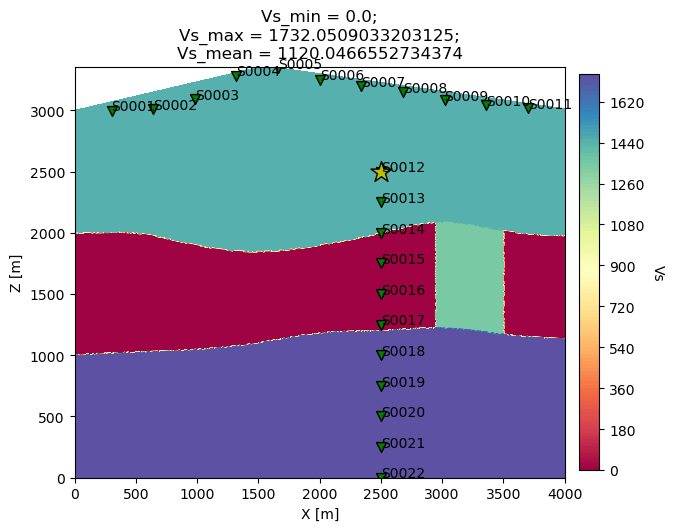

In [51]:
# We can use SeisFlows to plot this model in 2D as it knows hwo to read .bin files
m = Model(path="DATA")
m.plot2d(parameter="vs", show=False)

# Plot SOURCE and STATIONS on top of the model
for x_, z_, id_ in zip(sta_x, sta_z, sta_id):
    plt.scatter(float(x_), float(z_), c="g", marker="v", ec="k", s=50)
    plt.text(x_, z_, id_)
plt.scatter(ev_x, ev_z, c="y", marker="*", ec="k", s=250)

- Model above shows shear wave velocities (Vs) in a 2D domain
- Our model is defined by 3 distinct layers. 
    - Top: from Z=3500m down to Z=2000m, features a moderate velocity with topography at the surface (Z>3000m). 
    - Middle: from Z=2000m down to Z=1000m shows a low velocity zone with a high-velocity column (turquoise square). 
    - Bottom: from Z=1000m to Z=0m, features a realtively fast velocity. 
- 22 Station locations (green triangles), along the top boundary, and in a 'borehole' below the event
- 1 event, yellow star, colocated with station S0012
- Each interface (topography and contact between layers), was defined in a file specified by `Par_file` parameter `interfacesfile`.

In [71]:
# We can compare the interface file with the mesh above
! head -39 EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat | tail -n 34

# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000


### b) Synthetic waveforms

- During the simulation, `xspecfem2D` initiated the `SOURCE` file at time 0. 
- Over the course of the simulation, seismic waves propogated outward and were recorded at synthetic receiver locations defined by the `STATIONS` file. 
- Each `STATION` therefore has a corresponding synthetic seismogram located in the *OUTPUT_FILES/* directory.
- We specified output in units of displacement with parameter `seismotype`, so our synthetics have the file extension `.semd`
- Here, 'd' stands for displacement. Velocity seismograms would be extension'ed `.semv`, acceleration `.sema`. This is the same in SPECFEM3D
- Synthetic waveforms can be generated in a variety of formats. For simplicity we have chosen to output our synthetics in ACSII format. These ASCII files are two columns, representing time and amplitude, respectively.

In [72]:
# We have generated synthetics for each station location shown above
! ls OUTPUT_FILES/*.semd

OUTPUT_FILES/AA.S0001.BXX.semd	OUTPUT_FILES/AA.S0012.BXX.semd
OUTPUT_FILES/AA.S0001.BXZ.semd	OUTPUT_FILES/AA.S0012.BXZ.semd
OUTPUT_FILES/AA.S0002.BXX.semd	OUTPUT_FILES/AA.S0013.BXX.semd
OUTPUT_FILES/AA.S0002.BXZ.semd	OUTPUT_FILES/AA.S0013.BXZ.semd
OUTPUT_FILES/AA.S0003.BXX.semd	OUTPUT_FILES/AA.S0014.BXX.semd
OUTPUT_FILES/AA.S0003.BXZ.semd	OUTPUT_FILES/AA.S0014.BXZ.semd
OUTPUT_FILES/AA.S0004.BXX.semd	OUTPUT_FILES/AA.S0015.BXX.semd
OUTPUT_FILES/AA.S0004.BXZ.semd	OUTPUT_FILES/AA.S0015.BXZ.semd
OUTPUT_FILES/AA.S0005.BXX.semd	OUTPUT_FILES/AA.S0016.BXX.semd
OUTPUT_FILES/AA.S0005.BXZ.semd	OUTPUT_FILES/AA.S0016.BXZ.semd
OUTPUT_FILES/AA.S0006.BXX.semd	OUTPUT_FILES/AA.S0017.BXX.semd
OUTPUT_FILES/AA.S0006.BXZ.semd	OUTPUT_FILES/AA.S0017.BXZ.semd
OUTPUT_FILES/AA.S0007.BXX.semd	OUTPUT_FILES/AA.S0018.BXX.semd
OUTPUT_FILES/AA.S0007.BXZ.semd	OUTPUT_FILES/AA.S0018.BXZ.semd
OUTPUT_FILES/AA.S0008.BXX.semd	OUTPUT_FILES/AA.S0019.BXX.semd
OUTPUT_FILES/AA.S0008.BXZ.semd	OUTPUT_FILES/AA.S0019.BXZ.semd
OUTPUT_F

In [73]:
# The first 10 lines of a seismogram show the two-column (time, amplitude) format
! head -10 OUTPUT_FILES/AA.S0001.BXX.semd

 -0.12000000000000000          0.0000000000000000     
 -0.11889999999999999          0.0000000000000000     
 -0.11780000000000000          0.0000000000000000     
 -0.11670000000000000          0.0000000000000000     
 -0.11559999999999999          0.0000000000000000     
 -0.11449999999999999          0.0000000000000000     
 -0.11340000000000000          0.0000000000000000     
 -0.11230000000000000          0.0000000000000000     
 -0.11119999999999999          0.0000000000000000     
 -0.11009999999999999          0.0000000000000000     


Text(0, 0.5, 'Displacement [m]')

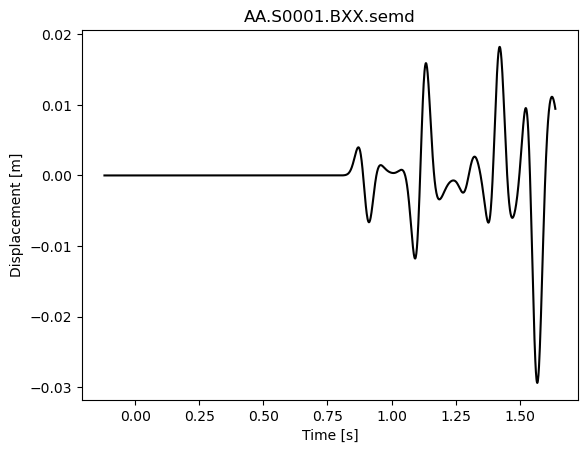

In [80]:
# We can easily plot these using NumPy and Matplotlib
data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)
plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

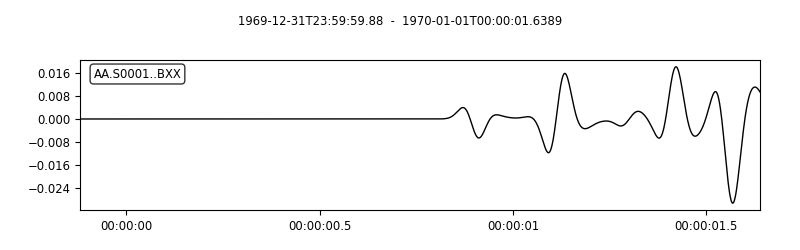

In [81]:
# SeisFlows also has a simple command line tool to plot seismograms using ObsPy
! seisflows plotst OUTPUT_FILES/AA.S0001.BXX.semd --savefig AA.S0001.BXX.semd.png
Image("AA.S0001.BXX.semd.png")

[2022-09-16 23:54:13] - pysep - INFO: starting record section plotter
[2022-09-16 23:54:13] - pysep - INFO: Reading 44 synthetics from: OUTPUT_FILES/
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0001.BXX.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0001.BXZ.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0002.BXX.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0002.BXZ.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0003.BXX.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0003.BXZ.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0004.BXX.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0004.BXZ.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0005.BXX.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0005.BXZ.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0006.BXX.semd
[2022-09-16 23:54:13] - pysep - DEBUG: OUTPUT_FILES/AA.S0006.BXZ.semd
[2022-09-1

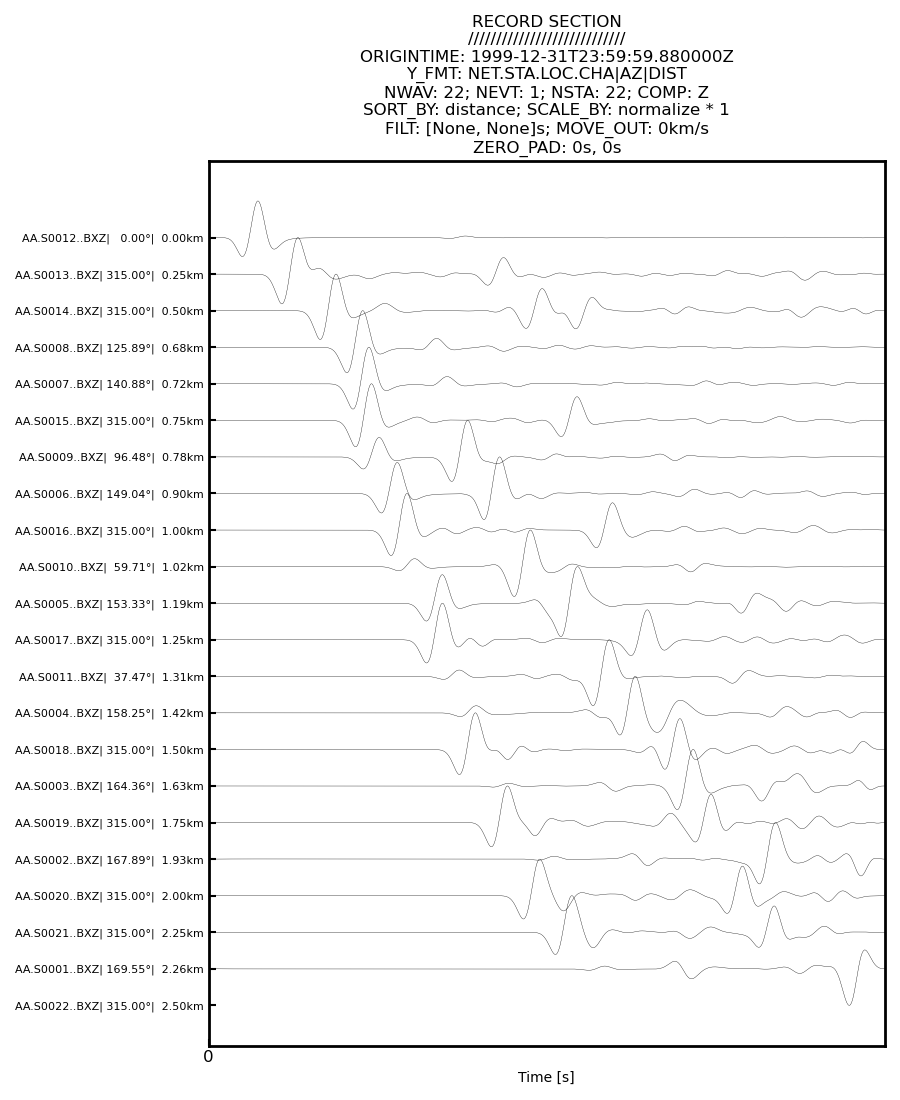

In [84]:
# We can use PySEP's record section (RecSec) tool to plot SPECFEM2D synthetics
# Because SPECFEM2D's SOURCE files don't contain origin time information, RecSec uses a dummy time
! recsec --syn_path OUTPUT_FILES/ --cmtsolution DATA/SOURCE --stations DATA/STATIONS --cartesian --overwrite
Image("record_section.png")

### c) SPECFEM2D Wavefield Snapshots 

- `xspecfem2D` generates snapshots of the forward wavefield. 
- These are automatically generated during a simulation as .jpg files
- The `Par_file` parameter `NTSTEP_BETWEEN_OUTPUT_IMAGES` controls how often it generates figures during a simulation. 
- We can see below that `DT`=.0011, so we output images every 0.11s of simulation time. 

In [85]:
# Use sempar to display parameter values
! seisflows sempar -P DATA/Par_file ntstep_between_output_images
! seisflows sempar -P DATA/Par_file dt

NTSTEP_BETWEEN_OUTPUT_IMAGES: 100
DT: 0.0011


In [86]:
# Wavefield snapshots every 100 time steps
! ls OUTPUT_FILES/*.jpg

OUTPUT_FILES/forward_image000000005.jpg
OUTPUT_FILES/forward_image000000100.jpg
OUTPUT_FILES/forward_image000000200.jpg
OUTPUT_FILES/forward_image000000300.jpg
OUTPUT_FILES/forward_image000000400.jpg
OUTPUT_FILES/forward_image000000500.jpg
OUTPUT_FILES/forward_image000000600.jpg
OUTPUT_FILES/forward_image000000700.jpg
OUTPUT_FILES/forward_image000000800.jpg
OUTPUT_FILES/forward_image000000900.jpg
OUTPUT_FILES/forward_image000001000.jpg
OUTPUT_FILES/forward_image000001100.jpg
OUTPUT_FILES/forward_image000001200.jpg
OUTPUT_FILES/forward_image000001300.jpg
OUTPUT_FILES/forward_image000001400.jpg
OUTPUT_FILES/forward_image000001500.jpg
OUTPUT_FILES/forward_image000001600.jpg


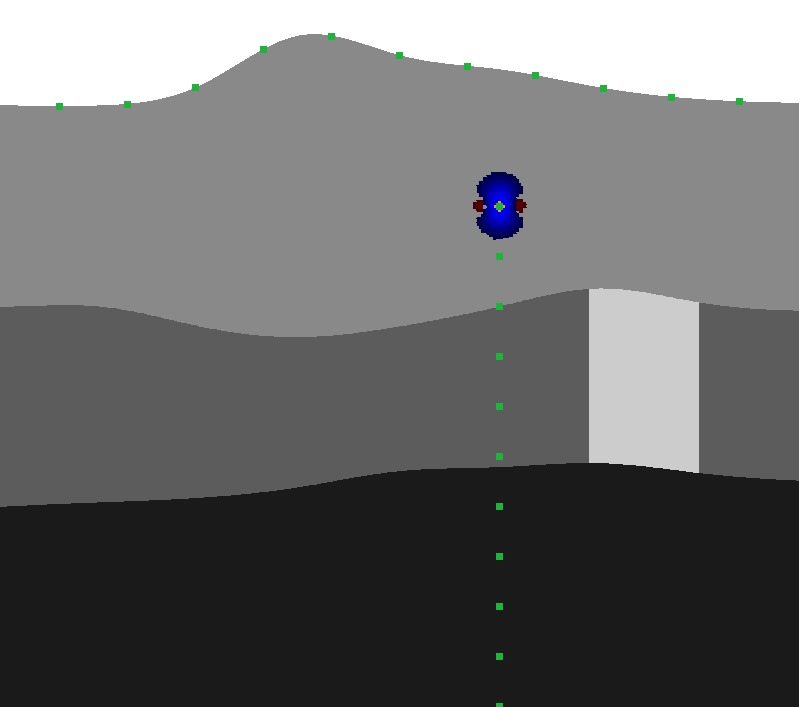

In [87]:
# Forward wavefield at NSTEP=100, T=.11s
Image("OUTPUT_FILES/forward_image000000100.jpg")

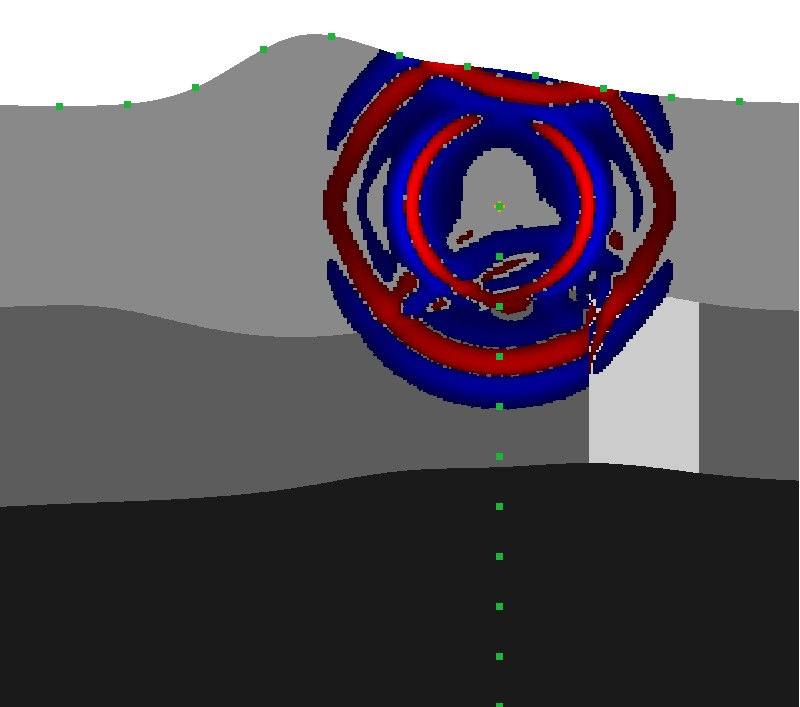

In [88]:
# Forward wavefield at NSTEP=400, T=.44s
Image("OUTPUT_FILES/forward_image000000400.jpg")

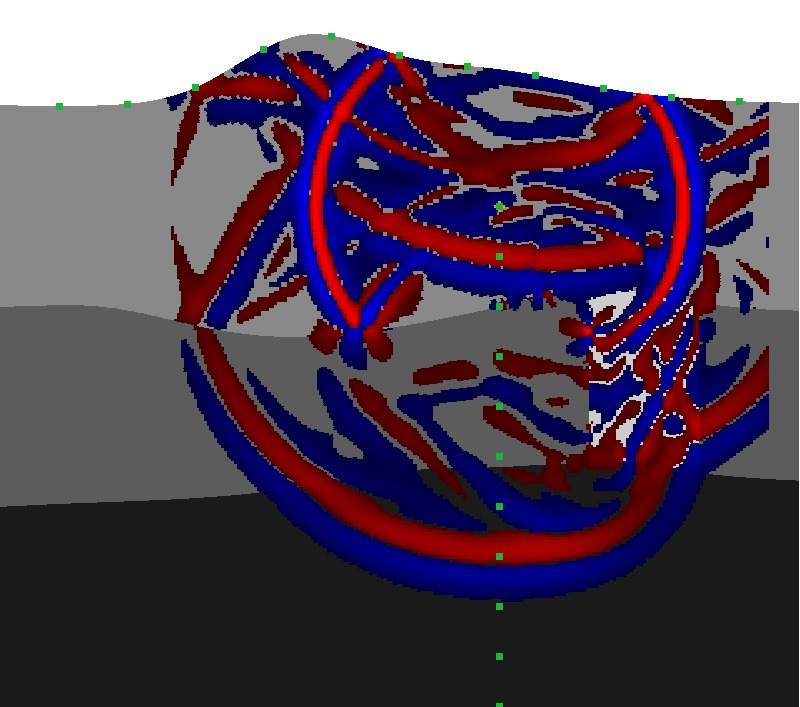

In [89]:
# Forward wavefield at NSTEP=700, T=.77s
Image("OUTPUT_FILES/forward_image000000700.jpg")

## 6) Conclusions

- In this notebook we explored SPECFEM2D, and learned to run the default example mesh generation and forward simulation.  
- We took a look at the most important files required for a simulation, and how User's can manipulate various parameters and files to run their own simulations. 
- We had a look at the results of a SPECFEM2D simulation, including waveforms, models, and wavefield snapshots.